In [5]:
import numpy as np
import qibo
from boostvqe.models.dbi.group_commutator_iteration_transpiler import DoubleBracketRotationType

In [6]:
from boostvqe.utils import *
gci = initialize_gci_from_vqe()
print_vqe_comparison_report(gci)

[Qibo 0.2.9|INFO|2024-06-19 18:26:39]: Using numpy backend on /CPU:0
[Qibo 0.2.9|INFO|2024-06-19 18:26:39]: Using numpy backend on /CPU:0
INFO:qibo.config:Using numpy backend on /CPU:0


In the VQE numpy
VQE energy is -14.8569 and the DBQA yields -14.8569. 
The target energy is -15.27613 which means the difference is for VQE     0.41923 and of the DBQA 0.41923         which can be compared to the spectral gap 1.08767.
The relative difference is for VQE 2.74436%     and for DBQA 2.74436%.The energetic fidelity witness for the ground state for the
      VQE is 0.61456 
        and DBQA 0.61456


In [7]:
def get_gd_evolution_oracle(n_local, params):
    if n_local == 1:
        return MagneticFieldEvolutionOracle(params)
    elif n_local == 2:
        return IsingNNEvolutionOracle(params[:int(len(params)/2)], params[int(len(params)/2):])
    else:
        raise_error(ValueError, "Model not supported, change `n_local` to values in [1, 2]")
     
def gradient_numerical(
    loss_function,
    n_local,
    params: list, 
    loss_0,
    s_0,
    delta: float = 1e-3,
):
    grad = np.zeros(len(params))
    for i in range(len(params)):
        params_new = deepcopy(params)
        params_new[i] += delta
        eo_d = get_gd_evolution_oracle(n_local, params_new)
        # find the increment of a very small step
        grad[i] = (loss_function(s_0, eo_d) - loss_0 ) / delta
        
    # normalize gradient
    grad = grad / max(abs(grad))
    return grad


def adapative_grid_search(loss_function, n_local, params, grad, s_min, s_max, lr_min, lr_max, initial_points, refinement_factor, max_iter, edge_threshold = 0.1):
    best_loss = float('inf')
    best_s = None
    best_lr = None
    last_best_loss = float('inf')
    # given max_iter, find num_refinment from geometric series
    # max_iter > initial_points*(refinement_factor^n-1)/(refinement_factor-1)
    iter_refinement = int(math.log((max_iter * (refinement_factor-1)/initial_points)+1)/math.log(refinement_factor))
    print(iter_refinement)
    for _ in range(iter_refinement):
        num_eval = n_points = int(np.sqrt(initial_points))
        s_values = np.linspace(s_min, s_max, num_eval)
        lr_values = np.linspace(lr_min, lr_max, num_eval)
    
        for s in s_values:
            for lr in lr_values:
                params_eval = deepcopy(params) - grad * lr
                eo_d = get_gd_evolution_oracle(n_local, params_eval)
                # Evaluate the loss function with the current parameters
                loss = loss_function(s, eo_d)
                if loss < best_loss:
                    best_loss = loss
                    best_s = s
                    best_lr = lr
        # condition to stop: worse than last round
        if best_loss > last_best_loss:
            print("break: perform worse than last round")
            break
        else:
            last_best_loss = best_loss
        # adjust range if best params too close to the edge
        s_range = s_max - s_min
        lr_range = lr_max - lr_min
        initial_points = int(initial_points * refinement_factor)
        
        if best_s - s_min < edge_threshold * s_range:
            s_min = max(s_min - s_range / refinement_factor, best_s * edge_threshold)
            s_max = min(s_max, best_s + (best_s - s_min))
            print(f"s {best_s} too small, now range: {s_min,s_max}")
        elif s_max - best_s <edge_threshold * s_range:
            s_max = min(s_max + s_range/refinement_factor, best_s / edge_threshold)
            s_min = max(s_min, best_s - (s_max - best_s))
            print(f"s {best_s} too big, now range: {s_min,s_max}")
        else:
            s_min, s_max = max(s_min, best_s - s_range / refinement_factor), min(s_max, best_s + s_range / refinement_factor)
        if best_lr - lr_min < edge_threshold * lr_range:
            lr_min = max(lr_min - lr_range / refinement_factor, best_lr * edge_threshold)
            lr_max = min(lr_max, best_lr + (best_lr - lr_min))
            print(f"lr {best_lr} too small, now range: {lr_min,lr_max}")
        elif lr_max - best_lr <edge_threshold * lr_range:
            lr_max = lr_max + lr_range/refinement_factor
            lr_min = max(lr_min, best_lr - (lr_max - best_lr))
            print(f"lr {best_lr} too big, now range: {lr_min,lr_max}")
        else:  
            lr_min, lr_max = max(lr_min, best_lr - (lr_max - lr_min) / refinement_factor), min(lr_max, best_lr + (lr_max - lr_min) / refinement_factor)
        
    best_params = params - grad * best_lr
    return best_s, best_lr, best_params, best_loss

In [22]:
def select_recursion_step_gd_circuit(gci, 
                    mode_dbr_list = [DoubleBracketRotationType.group_commutator_third_order], 
                    eo_d = None,
                    step_grid = np.linspace(1e-3,3e-2,10),
                    use_gd = False,
                    gd_steps = 1,
                    please_be_visual = False):
    """ Returns: circuit of the step, code of the strategy"""

    if eo_d is None:
        eo_d = gci.eo_d    
    if eo_d.name == "B Field":
        n_local = 1
        params = eo_d.b_list
    elif eo_d.name == "H_ClassicalIsing(B,J)":
        n_local = 2
        params = eo_d.b_list + eo_d.j_list
    else:
        raise_error(ValueError, "Evolution oracle type not supported.")
        
    minimal_losses = []
    all_losses = []
    minimizer_s = []
    for i,mode in enumerate(mode_dbr_list):

        gci.mode_double_bracket_rotation = mode
        # returns min_s, min_loss, loss_list
        s, l, ls = gci.choose_step(d = eo_d,step_grid = step_grid, mode_dbr = mode)
        if use_gd:
            ls = []
            train_s = s
            train_loss = l
            last_best_loss = l
            train_params = params
            stuck_counter = 0
            for _ in range(gd_steps):
                grad = gradient_numerical(gci.loss, n_local, train_params, train_loss, train_s)
                train_s, train_lr, train_params, train_loss = adapative_grid_search(gci.loss, n_local, train_params, grad, step_grid[0], step_grid[-1], 1e-3, 5, 20, 2, 120)
                if train_loss < l:
                    l = train_loss
                    s = train_s
                    eo_d = get_gd_evolution_oracle(n_local, train_params)
                    stuck_counter = 0
                elif train_loss > last_best_loss:
                    stuck_counter += 1
                last_best_loss = train_loss
                # break condition: worsening performance for 3 consecutive runs
                if stuck_counter == 3:
                    break
            # here optimize over gradient descent
            plot_s_grid = np.linspace(min(s, step_grid[0]), max(step_grid[-1], s),10)
            for step in plot_s_grid:
                ls.append(gci.loss(step, eo_d))
                
        minimal_losses.append(l)
        minimizer_s.append(s)
        
        if please_be_visual:
            plt.plot(plot_s_grid, ls)
            plt.yticks([ls[0],l, ls[-1]])
            plt.xticks([plot_s_grid[0],s,plot_s_grid[-1]])
            plt.show()
            
    minimizer_dbr_id = np.argmin(minimal_losses)
    
    return mode_dbr_list[minimizer_dbr_id], minimizer_s[minimizer_dbr_id], eo_d

In [23]:
b_list = [1+np.sin(x/3)for x in range(10)]
eo_d_m_field = MagneticFieldEvolutionOracle(b_list)
eo_d_nn = IsingNNEvolutionOracle(b_list, b_list)

2


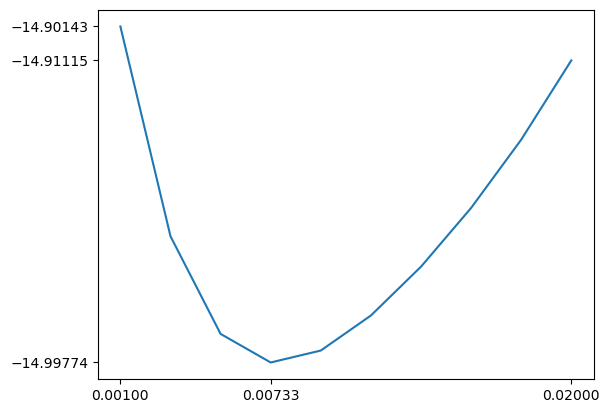

2
s 0.001 too small, now range: (0.0001, 0.0019)
lr 0.001 too small, now range: (0.0001, 0.0019)
s 0.0019 too big, now range: (0.001, 0.0028)
lr 0.0001 too small, now range: (1e-05, 0.00019)


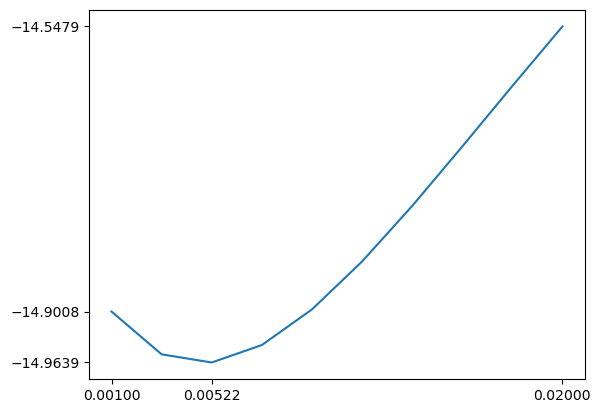

In [24]:
mode_dbr, minimizer_s, eo_d = select_recursion_step_gd_circuit(
    gci, mode_dbr_list = [DoubleBracketRotationType.group_commutator_third_order_reduced, 
                          DoubleBracketRotationType.group_commutator],
    eo_d = eo_d_nn,
    use_gd = True,
    step_grid = np.linspace(1e-3,2e-2,10),
    please_be_visual = True)
